In [2]:
import cv2
import sys
sys.path.append("../../")
sys.path.append("../donnees")
import skfmm
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] ="2"
# Tensorflow wizardry
config = tf.ConfigProto()
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
from skimage import data
#from skimage.filters import threshold_otsu, threshold_adaptive, threshold_local
from skimage.filters import median
from skimage.morphology import disk
from skimage.morphology import local_maxima
from skimage.morphology import dilation,cube,square,erosion,ball,disk
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2
from dlia_tools.u_net import u_net, u_net_non_binary
from dlia_tools.keras_image2image import DeadLeavesWithSegmGenerator
from dlia_tools.keras_custom_loss import jaccard2_loss, l1_loss, regression_loss
from dlia_tools.random_image_generator import AdditiveGaussianNoise
from dlia_tools.random_image_generator import ROG_disks, ROG_rings, RandomPosGenUniform, RandomIntGenUniform

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import scipy.io
#mat = scipy.io.loadmat('Neutral_Fiber_SPPI-0200_compacte/Coord_Fibres_Neutres.mat')
Image = io.imread('noncompacted.tif')
print(Image.shape)

(1798, 447, 1940)
Keys
dict_keys(['__header__', '__version__', '__globals__', 'CHEMINS_Warp', 'CHEMINS_Weft', 'Coordinate_Warp', 'Coordinate_Weft', 'InfoTomo', 'InfoWarp', 'InfoWeft', 'RESULTATS_Warp', 'RESULTATS_Weft'])


In [12]:
gt=[]
I=[]
for i in range (50,1781): #sens1
    gt.append(io.imread("pseudoGt/dist/slice"+str(i)+"dist.png"))
    I.append(Image[i,:,:])
gt=np.abs(np.asarray(gt))
I=np.abs(np.asarray(I))
print(gt.shape)
print(I.shape)

67509.0
(1798, 447, 1940)
(1731, 447, 1940)
(1731, 447, 1940)


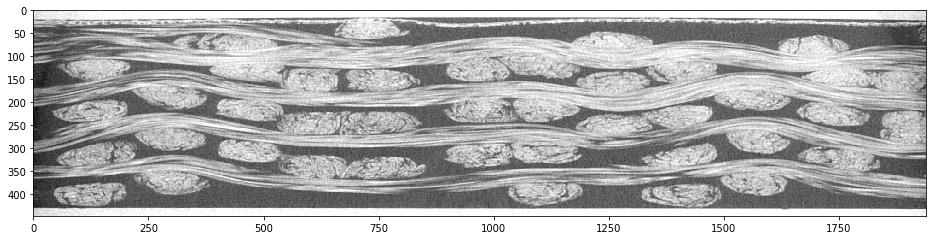

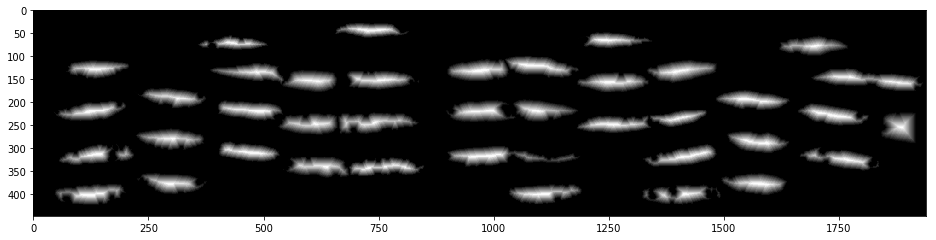

In [13]:
klayer=np.random.randint(0,gt.shape[2])
plt.figure(figsize=(16,16))
plt.imshow(I[klayer,:,:],cmap='gray')
plt.figure(figsize=(16,16))
plt.imshow(gt[klayer,:,:],cmap='gray')

In [14]:
SEpar=15
nb_train_samples = 10000
nb_val_samples = 1000
X_train=[]
Y_train=[]
X_val=[]
Y_val=[]
print(gt.shape)
print("train")
for i in range (0,nb_train_samples):
    klayer=np.random.randint(0,int(gt.shape[0]*(2/3)))
    xini=np.random.randint(gt.shape[1]-256)
    yini=np.random.randint(gt.shape[2]-256)
    coord=(xini,yini,klayer)
    X_train.append(I[klayer,xini:(xini+256),yini:(yini+256)])
    Y_train.append(gt[klayer,xini:(xini+256),yini:(yini+256)])
X_train=np.expand_dims(np.asarray(X_train),axis=3)
Y_train=np.expand_dims(np.asarray(Y_train),axis=3)
print("shape")
print(X_train.shape)
print(Y_train.shape)
print("val")    
for i in range (0,nb_val_samples):
    klayer=np.random.randint(int(gt.shape[0]*(2/3))+1,gt.shape[0])
    xini=np.random.randint(gt.shape[1]-256)
    yini=np.random.randint(gt.shape[2]-256)
    coord=(xini,yini,klayer)
    X_val.append(I[klayer,xini:(xini+256),yini:(yini+256)])
    Y_val.append(gt[klayer,xini:(xini+256),yini:(yini+256)])
X_val=np.expand_dims(np.asarray(X_val),axis=3)
Y_val=np.expand_dims(np.asarray(Y_val),axis=3)
print("shape")
print(X_val.shape)
print(Y_val.shape)

(1731, 447, 1940)
train
shape
(10000, 256, 256, 1)
(10000, 256, 256, 1)
val
shape
(1000, 256, 256, 1)
(1000, 256, 256, 1)


5728


Text(0.5,1,'Distance Map Ground truth')

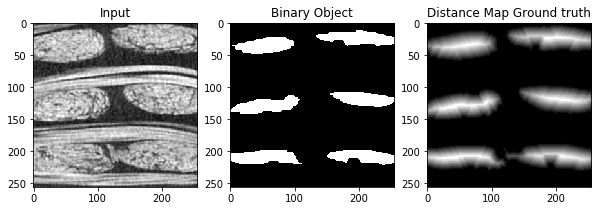

In [15]:
index = np.random.randint(nb_train_samples)
print(index)
plt.subplot(1, 3, 1)
plt.imshow(X_train[index, :, :, 0])
plt.title("Input")
plt.subplot(1, 3, 2)
plt.imshow(Y_train[index, :, :, 0]>127)
plt.title("Binary Object")
plt.subplot(1, 3, 3)
plt.imshow(Y_train[index, :, :, 0])
plt.title("Distance Map Ground truth")

In [17]:
# architecture params
nb_filters_0 = 8
sigma_noise = 0.01
img_channels=1
# ****  deep learning model
shape = (256, 256, img_channels)
model = u_net_non_binary(shape, nb_filters_0, sigma_noise=sigma_noise, activation_output="relu")

# ****  train
opt_name = 'adam'  # choices:adadelta; sgd, rmsprop, adagrad, adam
loss_func = 'mse'  # mse, mae, binary_crossentropy, jaccard2_loss, l1_loss, regression_loss
if opt_name == "sgd":
    opt = SGD(lr=0.1)
elif opt_name == "rmsprop":
    opt = RMSprop()
elif opt_name == "adagrad":
    opt = Adagrad()
elif opt_name == "adadelta":
    opt = Adadelta()
elif opt_name == "adam":
    opt = Adam(lr=1e-5)
else:
    raise NameError("Wrong optimizer name")
model.compile(loss=loss_func, optimizer=opt)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 256, 256, 8)  80          input_3[0][0]                    
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 256, 256, 8)  584         conv1_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 128, 128, 8)  0           conv1_2[0][0]                    
__________________________________________________________________________________________________
conv2_1 (C

In [18]:
import keras
# fit params
batch_size = 24#128

nb_epoch = 80

verbose = 1
earlystop=keras.callbacks.EarlyStopping(monitor='val_loss',
                        patience=35, verbose=1,
                        mode='auto', baseline=None,
                        restore_best_weights=True)

history = model.fit(X_train/255., Y_train/255.,
                    batch_size=batch_size,
                    epochs=nb_epoch,
                    validation_data=(X_val/255., Y_val/255.),
                    shuffle=True,
                    verbose=verbose,
                    callbacks=[earlystop])


Train on 10000 samples, validate on 1000 samples
Epoch 1/80
10000/10000 [==============================] - 47s 5ms/step - loss: 0.0544 - val_loss: 0.0487
Epoch 2/80
10000/10000 [==============================] - 41s 4ms/step - loss: 0.0355 - val_loss: 0.0234
Epoch 3/80
10000/10000 [==============================] - 46s 5ms/step - loss: 0.0180 - val_loss: 0.0187
Epoch 4/80
10000/10000 [==============================] - 46s 5ms/step - loss: 0.0148 - val_loss: 0.0167
Epoch 5/80
10000/10000 [==============================] - 46s 5ms/step - loss: 0.0132 - val_loss: 0.0159
Epoch 6/80
10000/10000 [==============================] - 44s 4ms/step - loss: 0.0119 - val_loss: 0.0146
Epoch 7/80
10000/10000 [==============================] - 44s 4ms/step - loss: 0.0110 - val_loss: 0.0137
Epoch 8/80
10000/10000 [==============================] - 44s 4ms/step - loss: 0.0103 - val_loss: 0.0130
Epoch 9/80
10000/10000 [==============================] - 44s 4ms/step - loss: 0.0097 - val_loss: 0.0128
Epoch 

Epoch 78/80
10000/10000 [==============================] - 44s 4ms/step - loss: 0.0043 - val_loss: 0.0077
Epoch 79/80
10000/10000 [==============================] - 44s 4ms/step - loss: 0.0042 - val_loss: 0.0077
Epoch 80/80
10000/10000 [==============================] - 43s 4ms/step - loss: 0.0042 - val_loss: 0.0079


In [19]:
print("Best validation loss: %.5f" % (np.min(history.history['val_loss'])))
print("at: %d" % np.argmin(history.history['val_loss']))

Best validation loss: 0.00767
at: 78


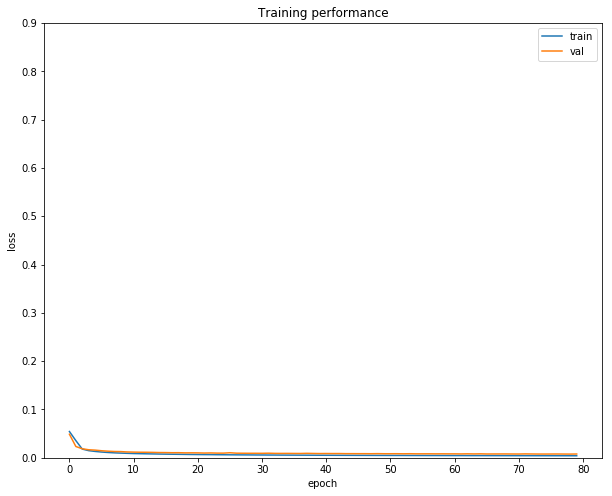

In [20]:
plt.plot(history.epoch, history.history['loss'], label='train')
plt.plot(history.epoch, history.history['val_loss'], label='val')
plt.title('Training performance')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.ylim(0.0, 0.9)
plt.show()

In [21]:
test=[]
I=[]
for i in range (31,1921): #sens2
    test.append(io.imread("gt/gt/"+str(i)+".png"))
    I.append(Image[:,:,i].T)
test=np.abs(np.asarray(test))
I=np.abs(np.asarray(I))
print(test.shape)
print(I.shape)

(1890, 447, 1798)
(1890, 447, 1798)


1858
(10000, 256, 256)


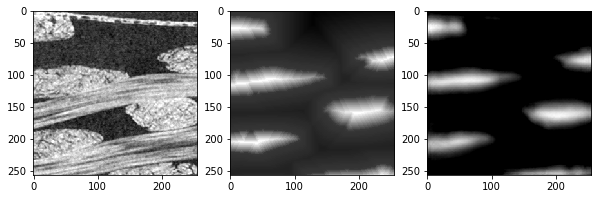

In [22]:
X_test=[]
Y_test=[]
index=np.random.randint(31,1921)
print(index)
for i in range (0,nb_train_samples):
    klayer=np.random.randint(test.shape[0])
    xini=np.random.randint(test.shape[1]-256)
    yini=np.random.randint(test.shape[2]-256)
    coord=(xini,yini,klayer)
    X_test.append(I[klayer,xini:(xini+256),yini:(yini+256)])
    Y_test.append(test[klayer,xini:(xini+256),yini:(yini+256)])
print(np.asarray(X_test).shape)
X_test=np.expand_dims(np.asarray(X_test),axis=3)
Y_test=np.expand_dims(np.asarray(Y_test),axis=3)
Y_pred = 255*model.predict(X_test/255.)
plt.subplot(1, 3, 1)
plt.imshow(X_test[index,:,:,0])
plt.subplot(1, 3, 2)
plt.imshow(Y_test[index,:,:,0])
plt.subplot(1, 3, 3)
plt.imshow(Y_pred[index,:,:,0])
plt.show()

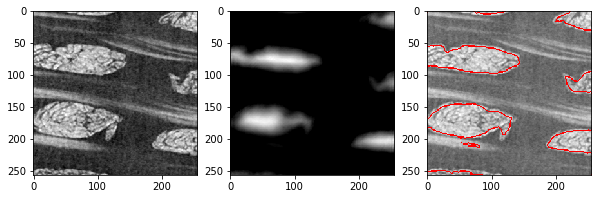

In [26]:
index = np.random.randint(nb_train_samples)
plt.subplot(1, 3, 1)
plt.imshow(X_test[index,:,:,0])
plt.subplot(1, 3, 2)
plt.imshow(Y_pred[index,:,:,0])
plt.subplot(1, 3, 3)
img=np.uint8(Y_pred[index,:,:,0]>0)
out=cv2.cvtColor(X_test[index,:,:,0],cv2.COLOR_GRAY2BGR)
dist_transform = cv2.distanceTransform(img,cv2.DIST_L1,5)
#out=(1-(dist_transform==2))&(1-(dist_transform==1))
#out[((1-(dist_transform==2))&(1-(dist_transform==1)))==0]=[255,0,0]
out[((1-(dist_transform==2))&(1-(dist_transform==1)))==0]=[255,0,0]
plt.imshow(out)
plt.show()

In [27]:
model.save_weights('weights_model_dist.hdf5')

In [28]:
shape = (None, None, img_channels)
modelLarge = u_net_non_binary(shape, nb_filters_0, sigma_noise=sigma_noise, activation_output="relu")
modelLarge.load_weights('weights_model_dist.hdf5')
modelLarge.compile(loss=loss_func, optimizer=opt)
print(modelLarge.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, None, None, 8 80          input_4[0][0]                    
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, None, None, 8 584         conv1_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, None, None, 8 0           conv1_2[0][0]                    
__________________________________________________________________________________________________
conv2_1 (C

In [ ]:
Input=[]#sens1
Output=[]
print(Image.shape)
multiple_of=32
for K in range (0,Image.shape[0]):
    ItoPred=Image[K,:,:]
    im_ori=np.expand_dims(ItoPred,axis=3)
    im_ori = np.pad(im_ori, ((0, multiple_of - im_ori.shape[0] % multiple_of),
                             (0, multiple_of - im_ori.shape[1] % multiple_of),
                             (0, 0)), 'reflect')
    Input.append(im_ori)

Input=np.array(Input)
print("shape")
print(Input.shape)

In [ ]:
Input=[]#sens1
Output=[]
print(Image.shape)
multiple_of=32
for K in range (0,Image.shape[0]):
    ItoPred=Image[K,:,:]
    im_ori=np.expand_dims(np.insert(np.insert(ItoPred, ItoPred.shape[1],np.zeros([12,1]), axis=1),ItoPred.shape[0],np.zeros([1,1]),axis=0),axis=3)
    Input.append(im_ori)

Input=np.array(Input)
print("shape")
print(Input.shape)

In [ ]:

Output=255.*modelLarge.predict(Input/255.)
for K in range (0,Image.shape[0]):
    cv2.imwrite("predmap/sens1/"+str(K)+".png",Output[K,0:447,0:1940,0])

In [ ]:
Input=[]#sens2
Output=[]
print(Image.shape)
multiple_of=32
for K in range (0,Image.shape[2]):
    ItoPred=Image[:,:,K].T
    im_ori=np.expand_dims(ItoPred,axis=3)
    im_ori = np.pad(im_ori, ((0, multiple_of - im_ori.shape[0] % multiple_of),
                             (0, multiple_of - im_ori.shape[1] % multiple_of),
                             (0, 0)), 'reflect')
    Input.append(im_ori)

Input=np.array(Input)
print("shape")
print(Input.shape)

In [30]:
Input=[]#sens2
Output=[]
print(Image.shape)
print(Image[:,:,2].T.shape)
multiple_of=32
for K in range (0,Image.shape[2]):
    ItoPred=Image[:,:,K].T
    im_ori=np.expand_dims(np.insert(np.insert(ItoPred, ItoPred.shape[1],np.zeros([26,1]), axis=1),ItoPred.shape[0],np.zeros([1,1]),axis=0),axis=3)
    Input.append(im_ori)

Input=np.array(Input)
print("shape")
print(Input.shape)

(1798, 447, 1940)
(447, 1798)


/home/haddad/anaconda3/envs/gpu/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  


shape
(1940, 448, 1824, 1)


In [31]:
Output=255.*modelLarge.predict(Input/255.)
#résultats
import cv2
for K in range (0,Image.shape[2]):
    cv2.imwrite("predmap/sens2/"+str(K)+".png",Output[K,0:447,0:1798,0])

(1731, 447, 1940)
43
(447, 1798)
(447, 1798)
<class 'numpy.uint8'>
<class 'numpy.uint8'>
(1940, 448, 1824, 1)


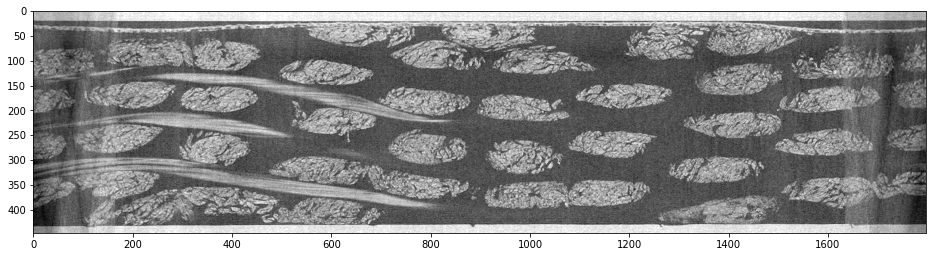

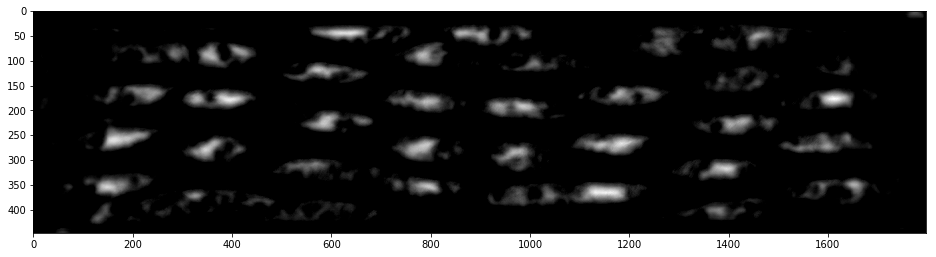

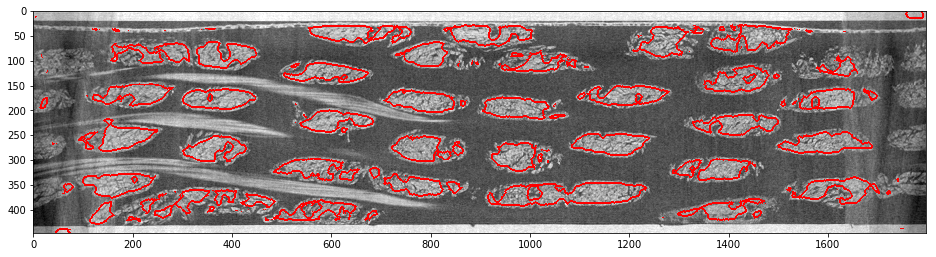

In [59]:
K=np.random.randint(0,gt.shape[2])
img=np.uint8(Output[K,0:447,0:1798,0])
token=1-np.uint8(img==0)
print(gt.shape)
print(K)
print(img.shape)
print(img.shape)
print(type(img[0][0]))
print(type(token[0][0]))
out=cv2.cvtColor(Input[K,0:447,0:1798,0],cv2.COLOR_GRAY2BGR)#cv2.imread("predmap/sens1/"+str(500)+".png",cv2.IMREAD_COLOR )
dist_transform = cv2.distanceTransform(img,cv2.DIST_L1,5)
print(Input.shape)
out[((1-((dist_transform<5)&(dist_transform>0))))==0]=[255,0,0]
plt.figure(figsize=(16,16))
plt.imshow(Input[K,0:447,0:1798,0],cmap='gray')
plt.figure(figsize=(16,16))
plt.imshow(img,cmap='gray')
plt.figure(figsize=(16,16))
plt.imshow(out,cmap='gray')

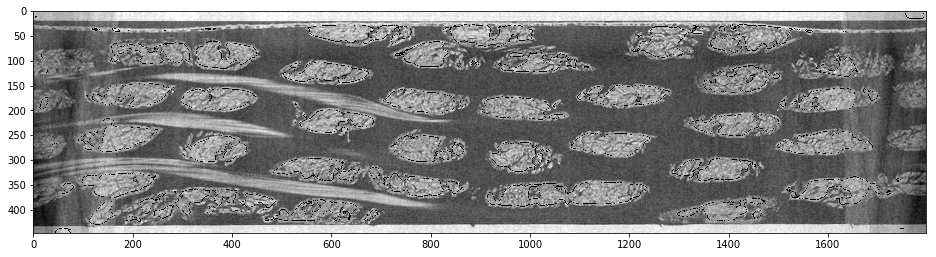

In [60]:
plt.figure(figsize=(16,16))
plt.imshow((dist_transform!=1)*(Input[K,0:447,0:1798,0]),cmap='gray')

In [ ]:
x=np.zeros([32,1])
y=np.ones([32,40])
print(y.shape)
print(y)
z=np.insert(np.insert(y, y.shape[1],np.zeros([32,1]), axis=1),y.shape[0],np.zeros([1,1]),axis=0)
print(z.shape)
print(z)